In [2]:
# --- 1. LIBRARIES & CONFIGURATION ---
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow_datasets as tfds  # For robust data loading
from tqdm import tqdm
from joblib import Parallel, delayed

# Machine Learning (Classical)
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Hardware Accelerator: {device}")
plt.style.use('seaborn-v0_8-whitegrid')

✅ Hardware Accelerator: cuda


In [3]:
# --- 2. DATA PIPELINE (Robust Loading via TFDS) ---
print("\n[PHASE 1] Data Acquisition & Preprocessing...")

# 2.1 Download Dataset (Automatic handling of zip/extraction)
# We use TensorFlow Datasets to avoid broken NIH zip links
ds, info = tfds.load('malaria', split='train', with_info=True, as_supervised=True)
print(f"   Dataset Size: {info.splits['train'].num_examples} images")

# 2.2 Preprocessing & Storage
# We save images to disk so PyTorch ImageFolder can read them standardly.
# This ensures both methods (RF and CNN) use the exact same files.
base_path = "./clean_data_full"
IMG_SIZE = 128 # 128x128 balances HOG speed and CNN accuracy

if not os.path.exists(base_path):
    print("   Processing images and saving to disk (One-time setup)...")
    os.makedirs(os.path.join(base_path, "Parasitized"))
    os.makedirs(os.path.join(base_path, "Uninfected"))

    count = 0
    # Process all images
    for image, label in tqdm(ds, desc="Saving", total=info.splits['train'].num_examples):
        image = image.numpy()
        label = label.numpy()

        # Resize and Color Fix (TFDS is RGB, OpenCV needs BGR)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # TFDS Mapping: 0=Parasitized, 1=Uninfected
        folder = "Parasitized" if label == 0 else "Uninfected"

        filename = os.path.join(base_path, folder, f"img_{count}.png")
        cv2.imwrite(filename, image)
        count += 1
    print("✅ Data preprocessing complete.")
else:
    print("✅ Data already found on disk.")


[PHASE 1] Data Acquisition & Preprocessing...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.06HPPV_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
   Dataset Size: 27558 images
   Processing images and saving to disk (One-time setup)...


Saving: 100%|██████████| 27558/27558 [00:44<00:00, 615.35it/s]

✅ Data preprocessing complete.


In [4]:
# --- 3. METHOD A: CLASSICAL COMPUTER VISION (HOG + RF) ---
print("\n[PHASE 2] Method A: Classical Baseline (HOG + Random Forest)...")

# 3.1 Load File Paths
import glob
parasitized_files = glob.glob(os.path.join(base_path, "Parasitized", "*.png"))
uninfected_files = glob.glob(os.path.join(base_path, "Uninfected", "*.png"))
print(f"   Loaded {len(parasitized_files)} Parasitized and {len(uninfected_files)} Uninfected paths.")

# 3.2 Parallel HOG Feature Extraction
# HOG is CPU intensive. We use joblib to parallelize across all cores.
def get_hog(path):
    img = cv2.imread(path, 0) # Grayscale
    # HOG Parameters: 9 orientations, 8x8 pixels per cell
    fd = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    return fd

print("   Extracting HOG features (Parallel CPU)...")
start_time = time.time()
# Extract features for all images
X_hog_p = Parallel(n_jobs=-1)(delayed(get_hog)(p) for p in parasitized_files)
X_hog_u = Parallel(n_jobs=-1)(delayed(get_hog)(p) for p in uninfected_files)

X_rf = np.array(X_hog_p + X_hog_u)
# Labels: 1 = Parasitized, 0 = Uninfected
y_rf = np.array([1] * len(X_hog_p) + [0] * len(X_hog_u))
hog_duration = time.time() - start_time
print(f"   Feature Extraction Time: {hog_duration:.1f}s")

# 3.3 Training
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

print("   Training Random Forest (100 estimators)...")
rf_start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
rf_train_time = time.time() - rf_start

# 3.4 Evaluation
y_pred_rf = rf_model.predict(X_test_rf)
acc_rf = accuracy_score(y_test_rf, y_pred_rf)
print(f"✅ Method A Accuracy: {acc_rf:.4f}")
print(f"   Training Duration: {rf_train_time:.1f}s")


[PHASE 2] Method A: Classical Baseline (HOG + Random Forest)...
   Loaded 13779 Parasitized and 13779 Uninfected paths.
   Extracting HOG features (Parallel CPU)...
   Feature Extraction Time: 180.9s
   Training Random Forest (100 estimators)...
✅ Method A Accuracy: 0.8307
   Training Duration: 388.8s


In [5]:
# --- 4. METHOD B: DEEP TRANSFER LEARNING (MobileNetV2) ---
print("\n[PHASE 3] Method B: Deep Learning (MobileNetV2)...")

# 4.1 Data Loaders (PyTorch)
# Standard ImageNet normalization
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(base_path, data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

loaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
}

# 4.2 Model Setup
model_ft = models.mobilenet_v2(weights='DEFAULT')
# Freeze backbone layers
for param in model_ft.parameters():
    param.requires_grad = False

# Replace classifier head
# MobileNetV2 features end with 1280 channels
model_ft.classifier[1] = nn.Sequential(
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=0.001)

# 4.3 Training Loop
history = {'acc': [], 'loss': []}
print("   Training CNN for 8 Epochs (GPU Accelerated)...")
dl_start = time.time()

for epoch in range(8):
    model_ft.train()
    for inputs, labels in tqdm(loaders['train'], desc=f"Epoch {epoch+1}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation step
    model_ft.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_acc = correct / total
    history['acc'].append(epoch_acc)
    print(f"   Epoch {epoch+1}: Val Acc {epoch_acc:.4f}")

dl_train_time = time.time() - dl_start
print(f"✅ Method B Training Complete ({dl_train_time:.1f}s)")


[PHASE 3] Method B: Deep Learning (MobileNetV2)...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 220MB/s]


   Training CNN for 8 Epochs (GPU Accelerated)...


   Epoch 1: Val Acc 0.9256


   Epoch 2: Val Acc 0.9245


   Epoch 3: Val Acc 0.9272


   Epoch 4: Val Acc 0.9282


   Epoch 5: Val Acc 0.9243


   Epoch 6: Val Acc 0.9276


   Epoch 7: Val Acc 0.9269


   Epoch 8: Val Acc 0.9296
✅ Method B Training Complete (254.8s)



[PHASE 4] Critical Analysis & Visualization...

--- REPORT DATA: TABLE I ---
              precision    recall  f1-score   support

 Parasitized       0.94      0.92      0.93      2751
  Uninfected       0.92      0.94      0.93      2761

    accuracy                           0.93      5512
   macro avg       0.93      0.93      0.93      5512
weighted avg       0.93      0.93      0.93      5512

DL Inference Speed: 1.06 ms/image


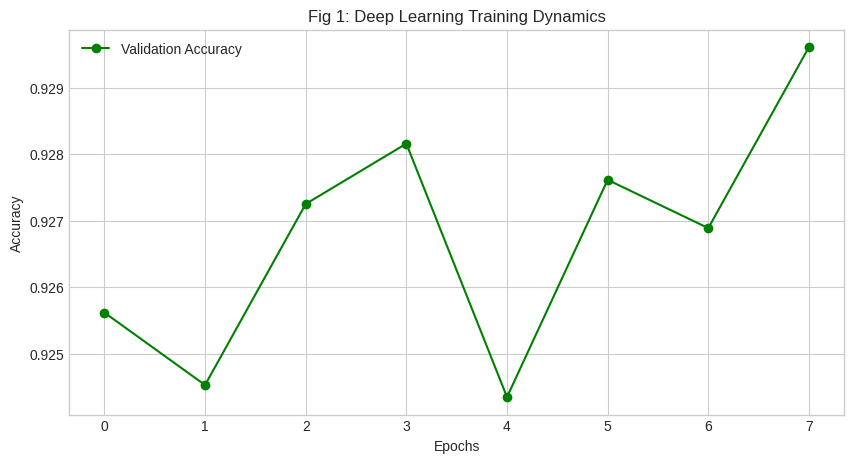

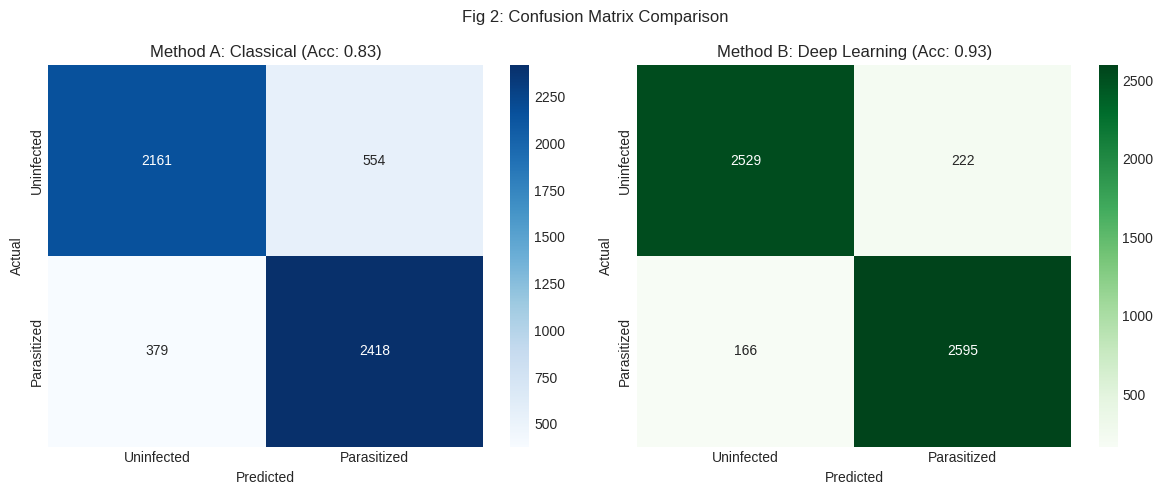

   Running Noise Robustness Test...


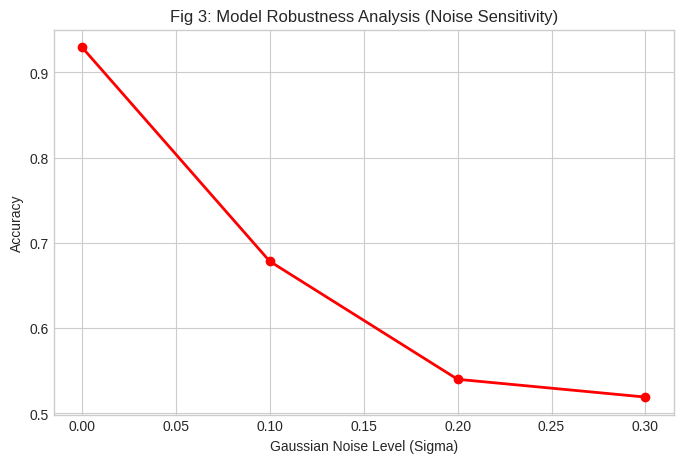

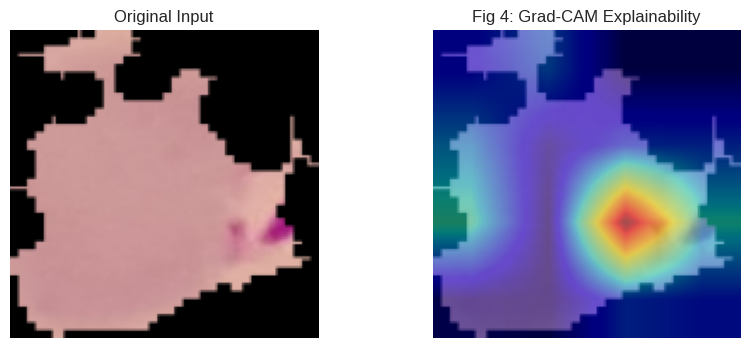


✅ PROJECT EXECUTION COMPLETE.


In [6]:
# --- 5. CRITICAL ANALYSIS & RESULTS GENERATION ---
print("\n[PHASE 4] Critical Analysis & Visualization...")

# 5.1 Metrics for Report Table I
# Get full predictions for DL
all_preds = []
all_labels = []
model_ft.eval()
start_infer = time.time()
with torch.no_grad():
    for inputs, labels in loaders['val']:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
infer_time = (time.time() - start_infer) * 1000 / len(all_labels) # ms per image

print("\n--- REPORT DATA: TABLE I ---")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))
print(f"DL Inference Speed: {infer_time:.2f} ms/image")

# 5.2 Figure 1: Training Curves
plt.figure(figsize=(10, 5))
plt.plot(history['acc'], marker='o', label='Validation Accuracy', color='green')
plt.title("Fig 1: Deep Learning Training Dynamics")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 5.3 Figure 2: Confusion Matrices
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
cm_dl = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f"Method A: Classical (Acc: {acc_rf:.2f})")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_xticklabels(['Uninfected', 'Parasitized'])
axes[0].set_yticklabels(['Uninfected', 'Parasitized'])

sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f"Method B: Deep Learning (Acc: {history['acc'][-1]:.2f})")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_xticklabels(['Uninfected', 'Parasitized'])
axes[1].set_yticklabels(['Uninfected', 'Parasitized'])

plt.suptitle("Fig 2: Confusion Matrix Comparison")
plt.tight_layout()
plt.show()

# 5.4 Figure 3: Robustness Stress Test (Noise Injection)
print("   Running Noise Robustness Test...")
noise_levels = [0.0, 0.1, 0.2, 0.3]
robust_acc = []

for n in noise_levels:
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loaders['val']:
            # Inject noise directly on normalized tensors
            noise = n * torch.randn_like(inputs)
            noisy_inputs = inputs + noise
            noisy_inputs = noisy_inputs.to(device)
            labels = labels.to(device)

            outputs = model_ft(noisy_inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    robust_acc.append(correct/total)

plt.figure(figsize=(8, 5))
plt.plot(noise_levels, robust_acc, marker='o', color='red', linewidth=2)
plt.title("Fig 3: Model Robustness Analysis (Noise Sensitivity)")
plt.xlabel("Gaussian Noise Level (Sigma)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# 5.5 Figure 4: Explainability (Grad-CAM)
# Simple Hook-based Grad-CAM implementation
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

# Register hooks on the last convolutional layer of MobileNet
target_layer = model_ft.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# Get one image
# We grab a batch and find a parasitized one
sample_img = None
for inputs, labels in loaders['val']:
    # Assuming class 0 is Parasitized (TFDS default)
    if labels[0] == 0:
        sample_img = inputs[0]
        break
if sample_img is None: sample_img = inputs[0] # Fallback

img = sample_img.unsqueeze(0).to(device)
img.requires_grad = True

# Forward pass
output = model_ft(img)
score = output[0][0] # Target class 0 (Parasitized)
score.backward()

# Generate Heatmap
grads = gradients.cpu().data.numpy().squeeze()
fmap = activations.cpu().data.numpy().squeeze()
weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(fmap.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * fmap[i, :, :]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (128, 128))
cam = (cam - np.min(cam)) / (np.max(cam) + 1e-8) # Normalize

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Un-normalize for display
disp_img = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
disp_img = disp_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
plt.imshow(np.clip(disp_img, 0, 1))
plt.title("Original Input")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(disp_img, 0, 1))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Fig 4: Grad-CAM Explainability")
plt.axis('off')
plt.show()

print("\n✅ PROJECT EXECUTION COMPLETE.")